In [1]:
from random import choice
from datetime import datetime
import json
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
from textblob import TextBlob
#from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
#BOW sklearn
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.corpus import stopwords
import nltk
import datetime as dt
import seaborn as sns
stop = stopwords.words('english')
#texts = texts.decode('utf8')
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/e75j/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
USER_AGENTS = [
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/65.0.3325.181 Safari/537.36']

#class that scrapes IG pages
class InstagramScraper:
    def __init__(self, url, user_agents=None):
        self.url = url
        self.user_agents = user_agents

    def __random_agent(self):
        if self.user_agents and isinstance(self.user_agents, list):
            return choice(self.user_agents)
        return choice(USER_AGENTS)

    def __request_url(self):
        try:
            response = requests.get(
                self.url,
                headers={'User-Agent': self.__random_agent()})
            response.raise_for_status()
        except requests.HTTPError:
            raise requests.HTTPError('Received non-200 status code.')
        except requests.RequestException:
            raise requests.RequestException
        else:
            return response.text

    @staticmethod
    def extract_json(html):
        soup = BeautifulSoup(html, 'html.parser')
        body = soup.find('body')
        script_tag = body.find('script')
        raw_string = script_tag.text.strip().replace('window._sharedData =', '').replace(';', '')
        return json.loads(raw_string)

    def page_metrics(self):
        results = {}
        try:
            response = self.__request_url()
            json_data = self.extract_json(response)
            metrics = json_data['entry_data']['ProfilePage'][0]['graphql']['user']
        except Exception as e:
            raise e
        else:
            for key, value in metrics.items():
                if key != 'edge_owner_to_timeline_media':
                    if value and isinstance(value, dict):
                        value = value['count']
                        results[key] = value
        return results

    def post_metrics(self):
        results = []
        try:
            response = self.__request_url()
            json_data = self.extract_json(response)
            metrics = json_data['entry_data']['ProfilePage'][0]['graphql']['user']['edge_owner_to_timeline_media'][
                'edges']
        except Exception as e:
            raise e
        else:
            for node in metrics:
                node = node.get('node')
                if node and isinstance(node, dict):
                    results.append(node)
        return results

In [5]:
url = 'https://www.instagram.com/alexcosta/?hl=en'
#Initiate a scraper object and call one of the methods.
instagram = InstagramScraper(url)
#pagemetrics shows followers count and count of who they follow
page_metrics = instagram.page_metrics()
followers = page_metrics['edge_followed_by']
post_metrics = instagram.post_metrics()
df = pd.DataFrame(post_metrics)
df = df.fillna(0)
commentCount = df['edge_media_to_comment'].apply(lambda x : sum(x.values()))
likesCount = df['edge_liked_by'].apply(lambda x : sum(x.values()))
videoviews = df['video_view_count'].fillna(0)
vidviewsCount = videoviews.sum()

#make a combined dataframe of num of likes and num of comments
combined =pd.concat([likesCount, commentCount], axis=1)
combined = combined.rename(columns={"edge_liked_by": "num_Likes", "edge_media_to_comment": "num_Comments"})
view = df[['is_video', 'taken_at_timestamp', 'video_view_count']]
dfmain = pd.concat([view, combined], axis = 1)
dfmain['taken_at_timestamp'] =  pd.to_datetime(dfmain['taken_at_timestamp'], unit= 's')
dfmain

,is_video,taken_at_timestamp,video_view_count,num_Likes,num_Comments
0,False,2019-09-01 16:50:09,0.0,70219,461
1,False,2019-08-31 16:19:38,0.0,66806,402
2,False,2019-08-30 17:20:23,0.0,76868,610
3,False,2019-08-29 17:24:55,0.0,56199,534
4,False,2019-08-28 14:42:28,0.0,64540,451
5,True,2019-08-27 15:13:17,74217.0,29035,218
6,True,2019-08-25 19:12:19,97110.0,38588,259
7,False,2019-08-24 16:32:58,0.0,69528,431
8,False,2019-08-22 17:29:14,0.0,60770,455
9,False,2019-08-21 17:56:34,0.0,60386,414


In [6]:
dfmain['video_view_count'].max()

97110.0

In [7]:
dfmain.rename(columns={'taken_at_timestamp': 'timestamp'}, inplace=True)
dfmain.rename(columns={'num_Likes': 'Likes'}, inplace=True)
dfmain.rename(columns={'num_Comments': 'Comments'}, inplace=True)
dfmain.rename(columns={'video_view_count': 'Video_views'}, inplace=True)

<Figure size 432x288 with 0 Axes>

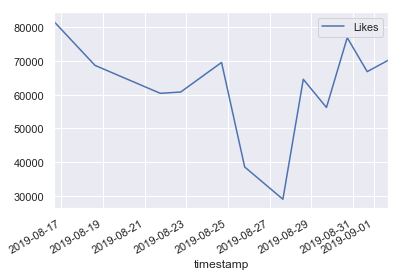

In [8]:
sns.set()
sns.despine()
#sns.set_palette("husl")
dfmain.plot(x='timestamp', y='Likes')


<Figure size 432x288 with 0 Axes>

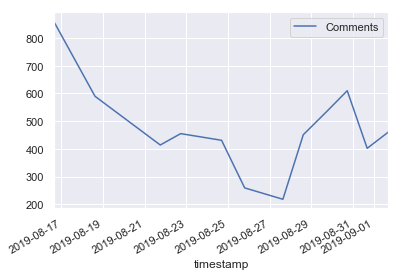

In [9]:
sns.set()
sns.despine()
dfmain.plot(x='timestamp', y='Comments')

<Figure size 432x288 with 0 Axes>

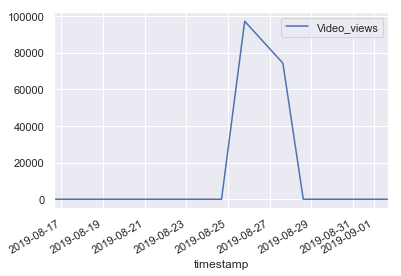

In [10]:
sns.set()
sns.despine()
dfmain.plot(x='timestamp', y='Video_views')

In [11]:
dfmain["Video_views"].max()

97110.0

In [12]:
average_likeCount = round(dfmain['Likes'].mean())
average_commentCount = round(dfmain['Comments'].mean())
engagement =100 * ((average_likeCount + average_commentCount) /followers)
averages = {'Like_avg': [average_likeCount], 'Comment_avg': [average_commentCount], 'Followers': [followers], 'Engagement': [engagement]}
df_averages = pd.DataFrame.from_dict(averages)

In [13]:
df_averages

,Like_avg,Comment_avg,Followers,Engagement
0,61944,474,719337,8.677157


In [15]:

#get all the captions from the last 12 posts and place into one big string
getwords = df['edge_media_to_caption']
getword_list = []
for index in range(len(getwords)):
    for key in getwords[index]:
        for key in getwords[index].get('edges'):
            getword_list.append(key)
            
ig_captions = []
for index in range(len(getword_list)):
    for key in getword_list[index]:
        for key in getword_list[index].get('node').get('text'):
            ig_captions.append(key)
ig_captions = ''.join(ig_captions)

In [16]:
ig_captions

'What a race! Thanks @heineken for having me and congrats @charles_leclerc on your first @f1 win 🏎  Swipe to see more! #heinekenf1Got to explore Antwerp and now I’m in Brussels patiently waiting for the @F1 Belgian Grand Prix tomorrow 🔥 Thanks for the incredible experience so far, @heineken! #heinekenf1\nDenim Jacket, chinos and white sneakers from BP x Alex Costa Collection at @nordstrom . Hoodie from @hiroclark.Off to Belgium for the @f1 Grand Prix with @heineken! Do you guys watch Formula 1? 🏎 Who do you think will win this weekend? \nTee and joggers: #bpxalexcosta\nSneakers: @balenciaga\nBags: @louisvuittonRepresenting my favorite city in the world with this hoodie from @verishop! They have hundreds of items on their website and offer free 2-day shipping on every order. Check my Story for a link to my favorites #ad #verishopBusy day ahead! Getting ready for a trip to Belgium then London and wearing all BP x Alex Costa 😎 Link in bio for the whole collection at @nordstrom #bpxalexcos

In [17]:
#remove numbers, remove emojis, remove links, removes nonaplhanumeric characters

captions = ig_captions.encode('ascii', 'ignore').decode('ascii')
captions = re.sub(r'^https?:\/\/.*[\r\n]*', '', captions, flags=re.MULTILINE)
captions = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",captions).split())
captions = ''.join([i for i in captions if not i.isdigit()])
captions = captions.lower()

In [18]:
#captions = ''.join(re.sub(r'\b\w{1,3}\b', '', captions)

In [19]:
#simple function that tokenizes and cleans words 
def preprocessing(text):
    text = text.encode().decode()
    # tokenize into words
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]

    # remove stopwords
    stop = stopwords.words('english')
    tokens = [token for token in tokens if token not in stop]

    # remove words less than three letters
    tokens = [word for word in tokens if len(word) >= 3]

    # lower capitalization
    tokens = [word.lower() for word in tokens]

    # lemmatize
    lmtzr = WordNetLemmatizer()
    tokens = [lmtzr.lemmatize(word) for word in tokens]
    preprocessed_text= ' '.join(tokens)

    return preprocessed_text 

In [20]:
captions = preprocessing(captions)

In [21]:
captions

'race thanks congrats leclerc first win swipe see heinekenfgot explore antwerp brussels patiently waiting belgian grand prix tomorrow thanks incredible experience far heinekenf denim jacket chino white sneaker alex costa collection hoodie belgium grand prix guy watch formula think win weekend tee jogger bpxalexcosta sneaker bag favorite city world hoodie hundred item website offer free day shipping every order check story link favorite verishopbusy day ahead getting ready trip belgium london wearing alex costa link bio whole collection bpxalexcosta nordstromhere style alex costa leather jacket available online store leatherjacket bpxalexcosta nordstrombp alex costa launch party hollywood hill hope everyone amazing time bpxalexcosta nordstrom weekend today official day shop clothing collection online store starting link bio also wanted take moment thank every one supported past year know story know wasnt always easy didnt get lucky thing didnt click right away work hard year get today a

In [22]:
captions_sent = TextBlob(captions)
captions_sent.sentiment.polarity

0.29904401154401156

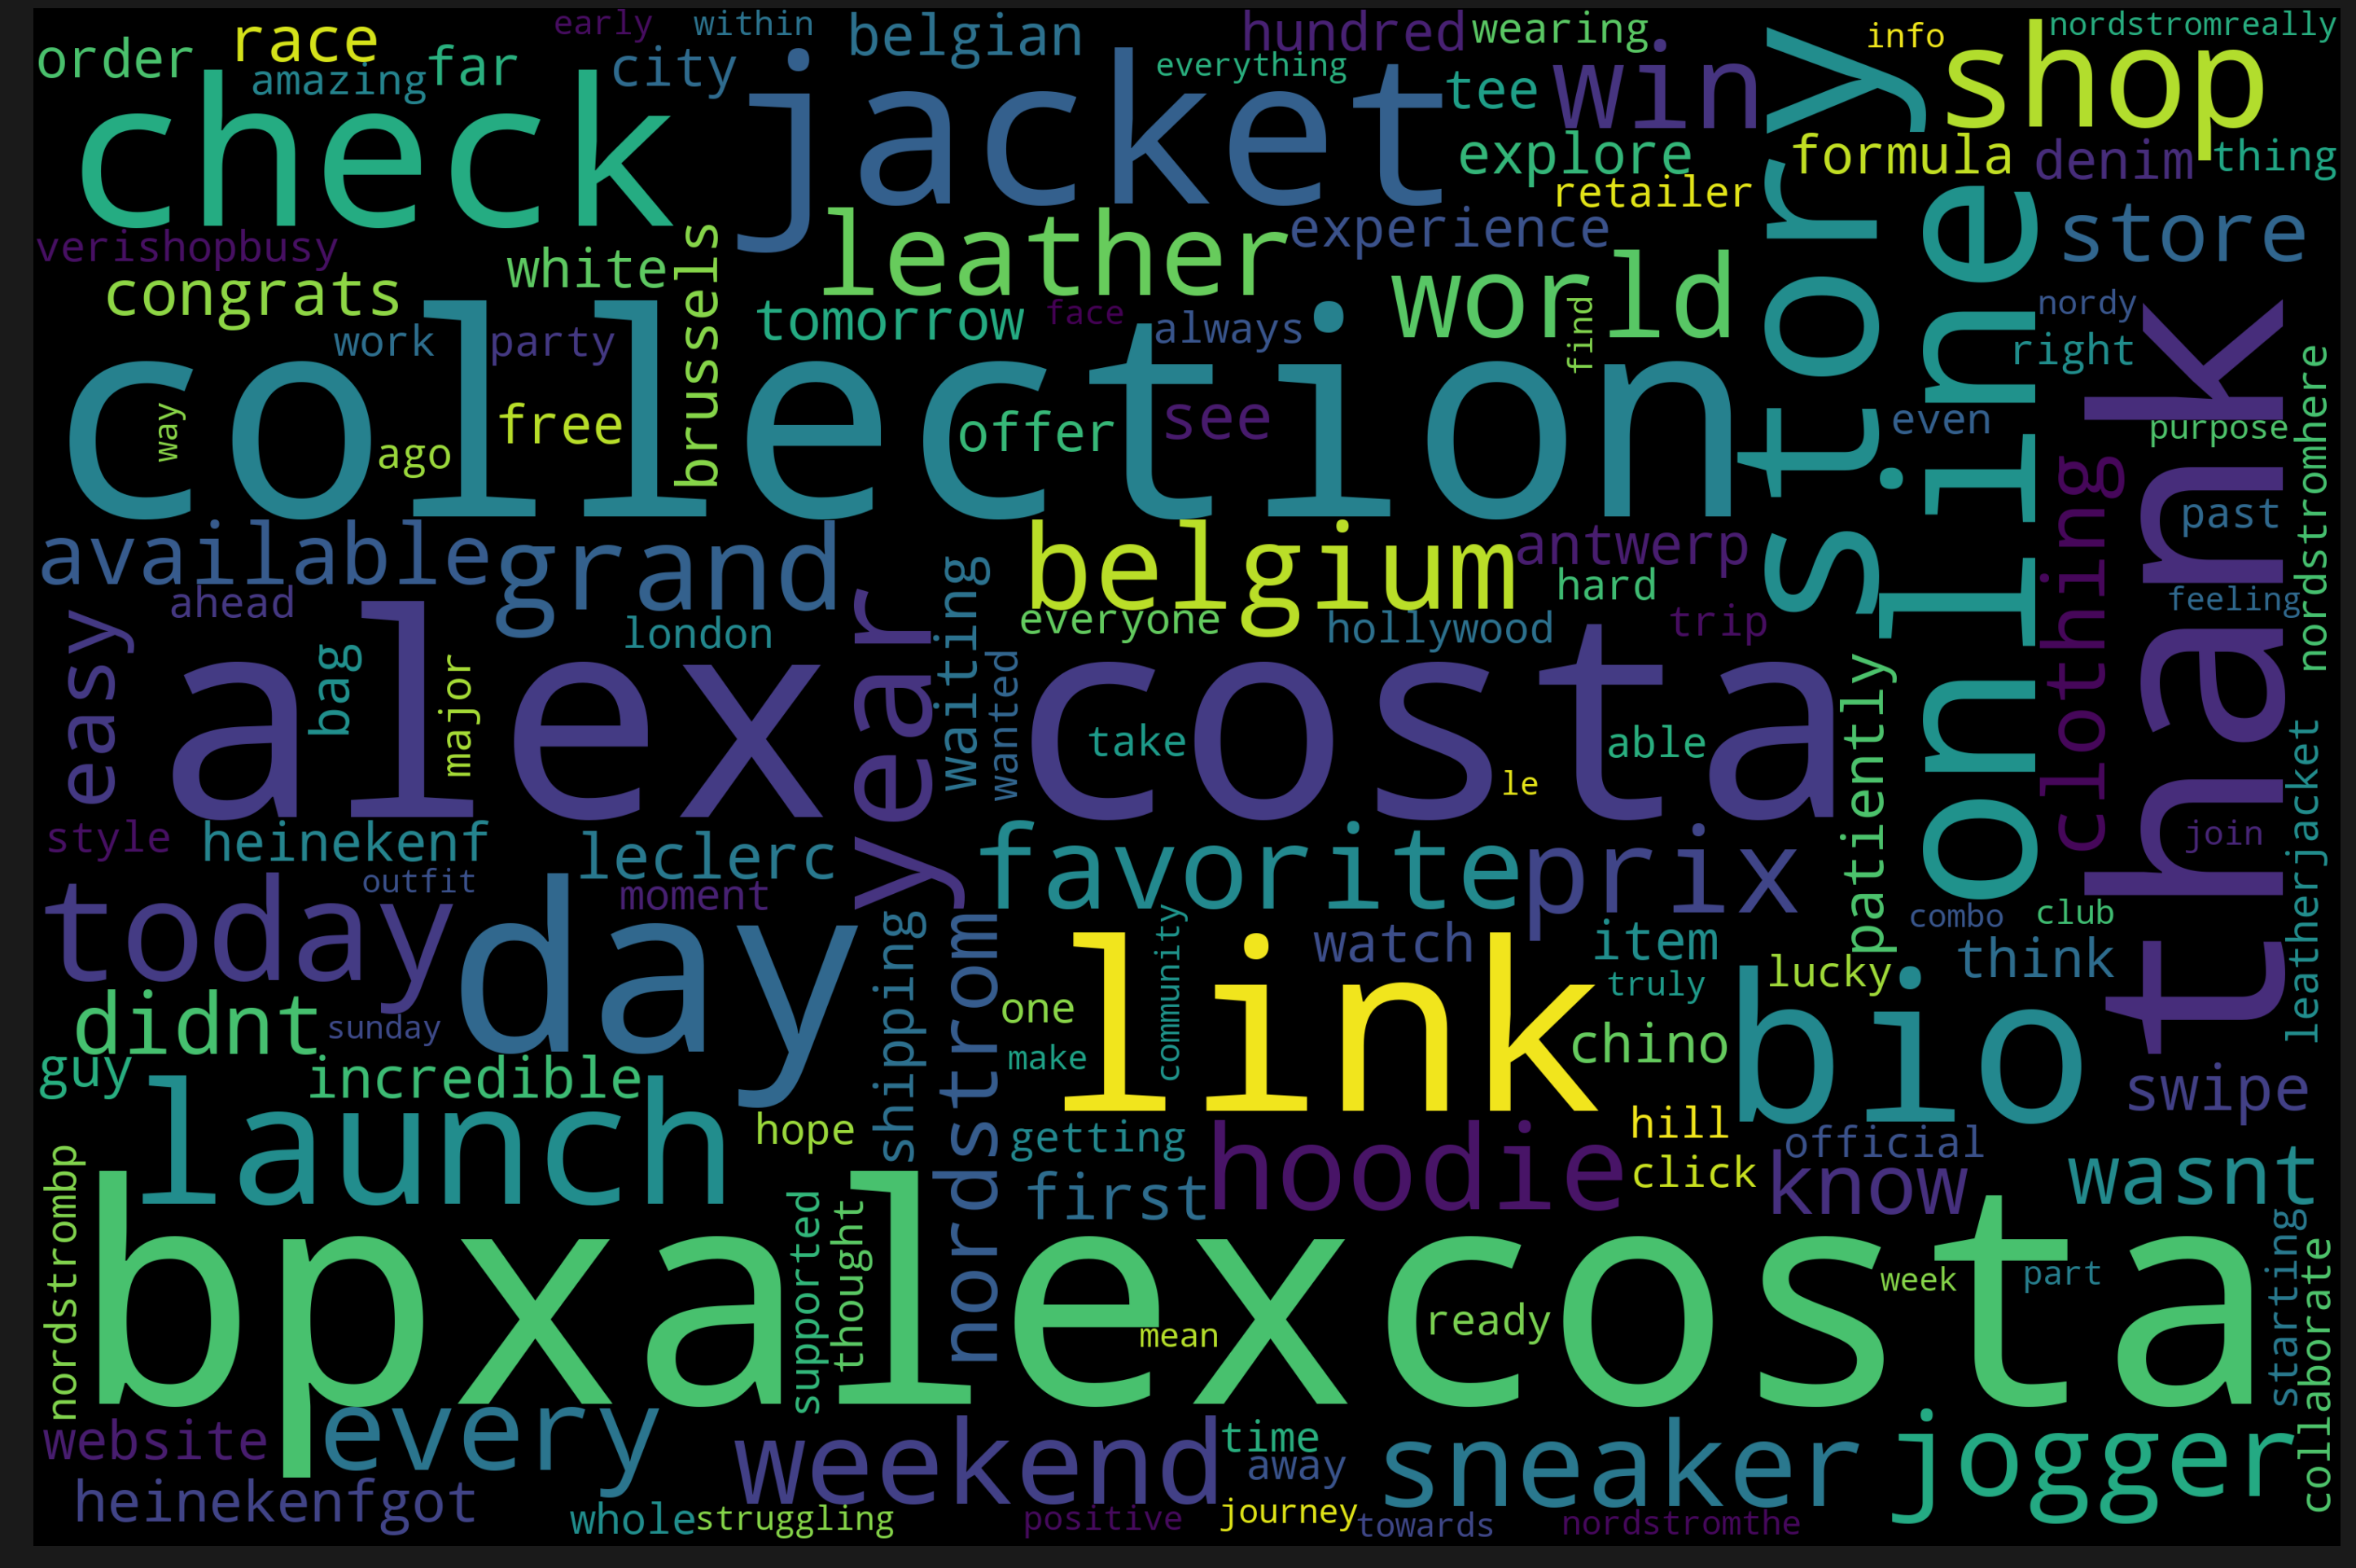

In [23]:
'''
Below is a function that takes in captions variable, uses NLTK/NLP pracitices to clean up the 
words before making a cool data cloud
'''

wordcloud_tweets = captions
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(wordcloud_tweets))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()